In [1]:
from datetime import datetime
from tqdm import tqdm
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
from typing import List
from pathlib import Path
from train.main.models import get_default_combined_sampler
import torch
from IPython.display import Audio
import warnings
from sklearn.metrics import average_precision_score

In [2]:
def mean_ap(df):
    # is equivalent to:
    # y_true = df.sci_name == df.detected_sci_name
    # return average_precision_score(y_true=y_true, y_score=df.confidence) # same as adding average="mikro"
    
    def get_ap(name):
        y_true = (df.sci_name == df.detected_sci_name).astype("int")
       
        y_score = df.confidence
        score = average_precision_score(y_true=y_true, y_score=y_score)
        return score
        
    return pd.Series(df.sci_name.unique()).map(get_ap).mean()


def mean_ap_subset(df):
    def get_ap(name):
        subset = df[df.sci_name == name]
        y_true = (subset.sci_name == subset.detected_sci_name).astype("int")

        # fixes warning recall = 0/0 
        if y_true.sum() == 0: return 0
       
        y_score = subset.confidence
        score = average_precision_score(y_true=y_true, y_score=y_score)
        return score
        
    return pd.Series(df.sci_name.unique()).map(get_ap).mean()


def prepare_for_sklearn(df):
    all_samples = set(df.file)
    get_sample_idx = {sample: i for i, sample in enumerate(all_samples)}
    
    all_classes = set(df.sci_name).union(set(df.detected_sci_name))
    get_class_idx = {c: i for i, c in enumerate(all_classes)}
    
    
    y_true = np.zeros((len(all_samples), len(all_classes))).astype("int32")
    y_score = np.zeros((len(all_samples), len(all_classes)))
    
    for i, x in df.iterrows():
        sample_idx = get_sample_idx[x.file]
        pred_class_idx = get_class_idx[x.detected_sci_name]
        true_class_idx = get_class_idx[x.sci_name]
        
        # there may be multiple detections for one class within one sample: use max confidence
        if y_score[sample_idx, pred_class_idx] >= x.confidence:
            continue
        else:
            y_score[sample_idx, pred_class_idx] = x.confidence
    
        y_true[sample_idx, true_class_idx] = 1

    return dict(y_true=y_true, y_score=y_score)


def get_macro_ap(df):
    all_samples = set(df.file)
    get_sample_idx = {sample: i for i, sample in enumerate(all_samples)}
    
    all_classes = set(df.sci_name).union(set(df.detected_sci_name))
    get_class_idx = {c: i for i, c in enumerate(all_classes)}
    
    
    y_true = np.zeros((len(all_samples), len(all_classes))).astype("int32")
    y_score = np.zeros((len(all_samples), len(all_classes)))
    
    for _, x in df.iterrows():
        sample_idx = get_sample_idx[x.file]
        pred_class_idx = get_class_idx[x.detected_sci_name]
        true_class_idx = get_class_idx[x.sci_name]
        
        # there may be multiple detections for one class within one sample: use max confidence
        if y_score[sample_idx, pred_class_idx] >= x.confidence:
            continue
        else:
            y_score[sample_idx, pred_class_idx] = x.confidence
    
        y_true[sample_idx, true_class_idx] = 1

    # classes that are only in detections not in files yield userwarning
    # can be ignored
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        ap_vals = average_precision_score(y_true=y_true, y_score=y_score, average=None)
    # average only over classes in files
    macro = pd.Series(df.sci_name.unique()).map(lambda name: ap_vals[get_class_idx[name]]).mean()
    return macro

In [21]:
exp_dir = "/data/tests/analysed"

step_exp = [
    "steps25_scale5_v3.csv",
    "steps50_scale5_v3.csv",
    "steps100_scale5_v3.csv",
    "steps200_scale5_v3.csv",
    "steps400_scale5_v3.csv",
    "steps800_scale5_v3.csv",
]
scale_exp = [
    "steps100_scale1_v3.csv",
    "steps100_scale2,5_v3.csv",
    "steps100_scale5_v3.csv",
    "steps100_scale10_v3.csv",
    "steps100_scale15_v3.csv",
]
model_exp = [
    "steps100_scale1_v2.csv", # v2 is without cfg -> only scale 1 sensible
    "steps100_scale10_v3.csv",
    "steps100_scale10_v3_strat.csv",
]

for exp in step_exp:
    print(exp[:-4])
    df = pd.read_csv(os.path.join(exp_dir, exp))

    sklearn_args = prepare_for_sklearn(df)

    # micro and macro use max detection conf for one file and dtetected class
    macro = get_macro_ap(df) 
    
    # questionalble as ap is also calculated over classes thet are in detections but not files
    micro = average_precision_score(**sklearn_args, average="micro")

    # over all detections
    subset_mean_ap = mean_ap_subset(df)    
    mean_ap_score = mean_ap(df)
    
    print(f"mAP: {mean_ap_score:.4f}")
    print(f"subset mAP: {subset_mean_ap:.4f}")
    print(f"sklearn macro ap: {macro:.4f}")
    print(f"sklearn micro ap: {micro:.4f}")
    print()


steps25_scale5_v3
mAP: 0.5230
subset mAP: 0.1458
sklearn macro ap: 0.2042
sklearn micro ap: 0.1086

steps50_scale5_v3
mAP: 0.5228
subset mAP: 0.1440
sklearn macro ap: 0.2003
sklearn micro ap: 0.1177

steps100_scale5_v3
mAP: 0.5255
subset mAP: 0.1395
sklearn macro ap: 0.2122
sklearn micro ap: 0.1279

steps200_scale5_v3
mAP: 0.5290
subset mAP: 0.1424
sklearn macro ap: 0.2078
sklearn micro ap: 0.1398

steps400_scale5_v3
mAP: 0.5446
subset mAP: 0.1426
sklearn macro ap: 0.2210
sklearn micro ap: 0.1433

steps800_scale5_v3
mAP: 0.5463
subset mAP: 0.1343
sklearn macro ap: 0.2101
sklearn micro ap: 0.1342



In [75]:
df2 = df.groupby(by=['detected_sci_name', 'file', 'sci_name'], as_index=False).max()

print(f"mAP: {mean_ap(df):.4f}")
print(f"mAP over max: {mean_ap(df2):.4f}")
print(f"subset mAP: {mean_ap_subset(df):.4f}")
print(f"subset mAP over max: {mean_ap_subset(df2):.4f}")
print(f"macro: {get_macro_ap(df):.4f}") # == macro over max
print(f"micro: {average_precision_score(**prepare_for_sklearn(df), average='micro'):.4f}") # == micro over max

mAP: 0.5446
mAP over max: 0.4442
subset mAP: 0.1426
subset mAP over max: 0.1819
macro: 0.2210
micro: 0.1433


In [22]:
exp_dir = "/data/tests/analysed"
steps = [25, 50, 100, 200, 400, 800]
macro_ap_steps = []
for step in tqdm(steps):
    df = pd.read_csv(os.path.join(exp_dir, f"steps{step}_scale5_v3.csv"))
    macro = get_macro_ap(df) 
    macro_ap_steps.append(macro)


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


[0.2041610048833833, 0.20028224244355655, 0.2122214203514063, 0.20778231366157532, 0.2210294278969043, 0.21007226091598685]


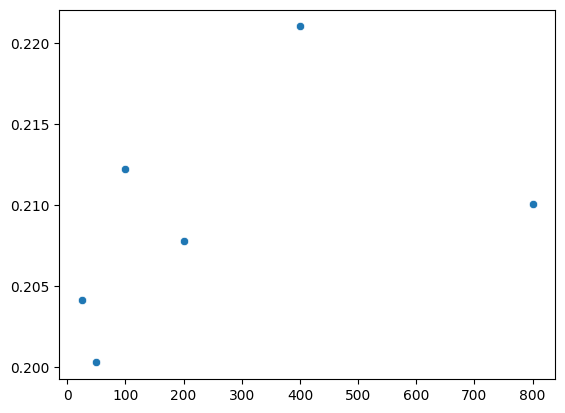

In [23]:
print(macro_ap_steps)
ax = sns.scatterplot(x=steps, y=macro_ap_steps)
plt.show()

In [26]:
exp_dir = "/data/tests/analysed"
scales = [1, 2.5, 5, 10, 15]
macro_ap_scale = []
for scale in tqdm(scales):
    scale_str = str(scale).replace(".", ",")
    df = pd.read_csv(os.path.join(exp_dir, f"steps100_scale{scale_str}_v3.csv"))
    macro = get_macro_ap(df) 
    macro_ap_scale.append(macro)

100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


[0.06647889912992105, 0.18017816193926264, 0.2122214203514063, 0.13687974636240047, 0.07997132459170762]


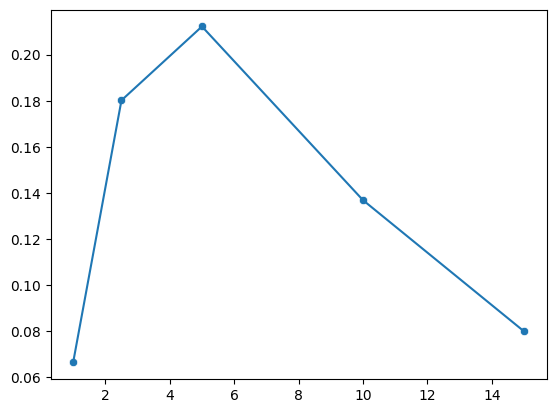

In [31]:
print(macro_ap_scale)
sns.scatterplot(x=scales, y=macro_ap_scale)
sns.lineplot(x=scales, y=macro_ap_scale)
plt.show()

In [ ]:
data_dir = "/data/tests/generated"
step_exp = [
    "steps25_scale5_v3",
    "steps50_scale5_v3",
    "steps100_scale5_v3",
    "steps200_scale5_v3",
    "steps400_scale5_v3",
    "steps800_scale5_v3",
]
scale_exp = [
    "steps100_scale1_v3",
    "steps100_scale2,5_v3",
    "steps100_scale5_v3",
    "steps100_scale10_v3",
    "steps100_scale15_v3",
]
model_exp = [
    "steps100_scale1_v2",
    "steps100_scale10_v2",
    "steps100_scale10_v3",
    "steps100_scale10_v3_strat",
]

audios = os.listdir(os.path.join(data_dir, "steps100_scale5_v3"))
for f in audios[:5]:
    print(f)
    for exp in step_exp:
        print(exp)
        display(Audio(filename=os.path.join(data_dir, exp, f)))

In [ ]:
#for exp in experiments:
    #print(exp[:-4])
    #
    #df = pd.read_csv(os.path.join(exp_dir, exp))
    #score = average_precision_score(y_true=y_true, y_score=y_score)
    #print(f"cds ap score: {score:.4f}")
    #score = roc_auc_score(y_true=y_true, y_score=y_score)
    #print(f"cds auroc score: {score:.4f}")
    #print("# detections @0.1: ", len(df))
    #print(f"mean conf among correct @0.1: {y_score[y_true].mean():.4f}")
    #print("# correct @0.1: ", y_true.sum())
    #detection = y_score > threshold
    #print(f"acc @0.1: {y_true.mean():.4f}")
    #print(f"acc @0.5: {y_true[detection].mean():.4f}")